In [2611]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report  
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

In [2612]:
pd.options.mode.chained_assignment = None 

In [2613]:
df = pd.read_csv('../data/train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [2614]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2615]:
df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

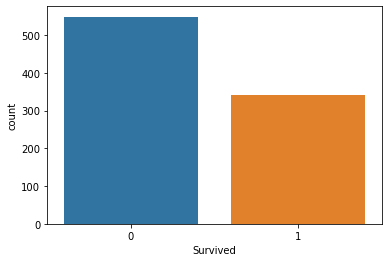

In [2616]:
sns.countplot(data=df,x='Survived')
None

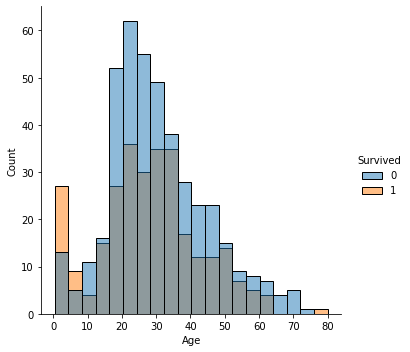

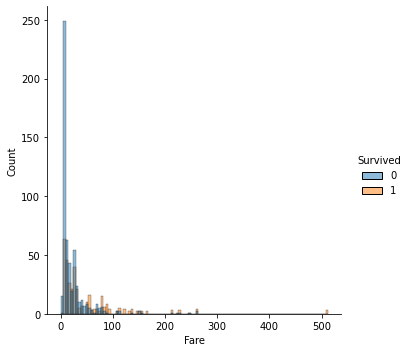

In [2617]:
import matplotlib.pyplot as plt
for column in ['Age','Fare']: #  left out:  Name, Ticket, Cabin 
    sns.displot(data=df, x=column, hue = 'Survived',alpha=0.5)
    plt.show()
    plt.close()
None
    

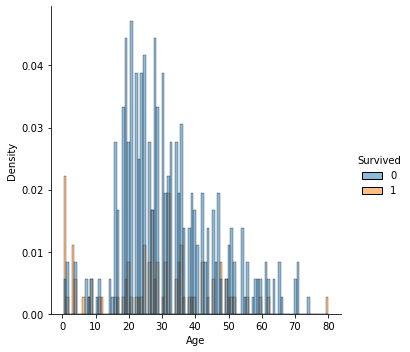

In [2618]:
sns.displot(data=df[df['Sex']=='male'], x="Age", hue = 'Survived',stat="density",bins=100)
None

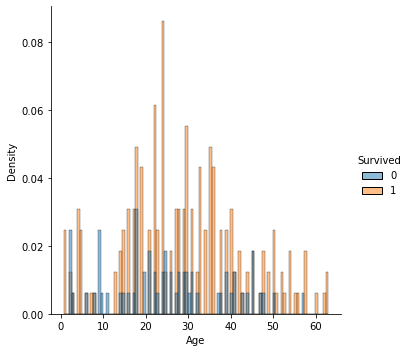

In [2619]:
sns.displot(data=df[df['Sex']=='female'], x="Age", hue = 'Survived',stat="density",bins=100)
None

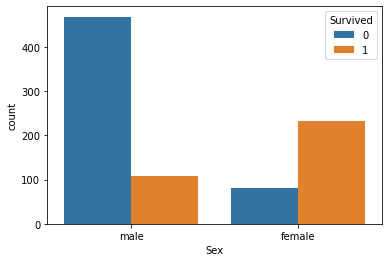

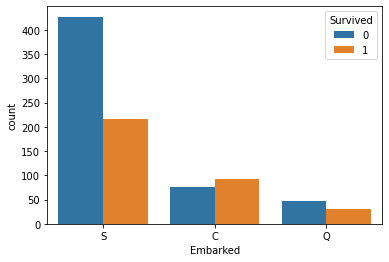

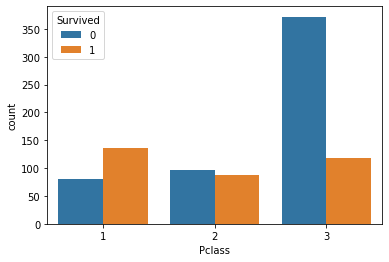

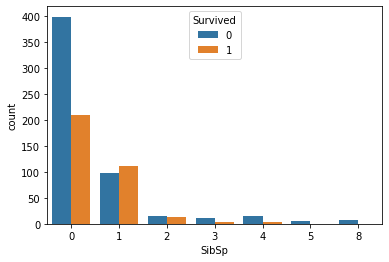

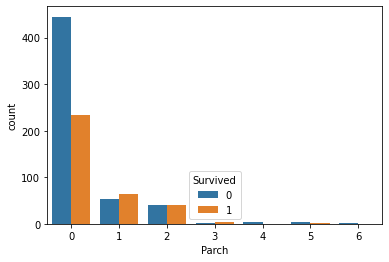

In [2620]:
import matplotlib.pyplot as plt
for column in ['Sex','Embarked','Pclass', 'SibSp','Parch',]:   
    sns.countplot(data=df, x=column,hue='Survived')
    plt.show()
    plt.close()
None

In [2621]:
df[['Cabin']].describe()

,Cabin
count,204
unique,147
top,B96 B98
freq,4


In [2622]:
df[['Ticket']].describe()

,Ticket
count,891
unique,681
top,347082
freq,7


In [2623]:
X = df[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Cabin','Ticket','Name',]]#
y = df['Survived']
X.shape,y.shape

((891, 10), (891,))

In [2624]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=37) 
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((712, 10), (712,), (179, 10), (179,))

In [2625]:
X_train['Alone'] = np.where((X_train['Parch']==0) & (X_train['SibSp']==0),1,0)
X_test['Alone'] = np.where((X_test['Parch']==0) & (X_test['SibSp']==0),1,0)
X_train['Alone'].value_counts()

1    435
0    277
Name: Alone, dtype: int64

In [2626]:
numerical_columns = ['Age','Fare',]
categorical_columns = ['Embarked','Pclass','Sex','SibSp','Parch','Alone'] #

In [2627]:
X_train.isna().sum()

Pclass        0
Sex           0
Age         135
SibSp         0
Parch         0
Fare          0
Embarked      1
Cabin       551
Ticket        0
Name          0
Alone         0
dtype: int64

# Starting with a minimal set features
* Age
* Pclass
* Sex
* Alone

In [2628]:
numerical_pipeline = Pipeline([
    ('numerical_imputer',SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('num_scaler',StandardScaler()),
    ('num_discritazer',KBinsDiscretizer(n_bins=10, strategy='uniform'),)
])

In [2629]:
categorical_pipeline = Pipeline([
    ('categorical_imputer',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('categorical_ohe',OneHotEncoder(sparse=False,drop='first')),
])

In [2630]:
column_transformer_minimal = ColumnTransformer([
    ('numerical_pipeline',numerical_pipeline,['Age',]),
    ('categorical_pipeline',categorical_pipeline,['Pclass','Sex','Alone',]),
])

In [2631]:
column_transformer_minimal.fit(X_train) #learn how to do the transforamtion
X_train_minimal = column_transformer_minimal.transform(X_train) #Do the accual transformation
X_test_minimal = column_transformer_minimal.transform(X_test) #Do the same transformation on test set 

In [2632]:
m_minimal = LogisticRegression() #class_weight='balanced'
m_minimal.fit(X_train_minimal,y_train) 
None

In [2633]:
cross_val_scores = cross_val_score(m_minimal, X_train_minimal, y_train, cv=10)
np.sort(cross_val_scores.round(3))
f"Mean cross-validation score: {cross_val_scores.mean(): 5.3f}"

'Mean cross-validation score:  0.806'

In [2634]:
y_pred_minimal = m_minimal.predict(X_test_minimal)

In [2635]:
score =accuracy_score(y_test,y_pred_minimal) 
score

0.7988826815642458

# Starting to add more features

In [2636]:
X_train['Cabin'].fillna("Unknown",inplace=True)


In [2637]:
for letter in ['A','B','C','D','E','F','G','U']:
    print(X_train[X_train['Cabin'].str.contains(letter)]['Pclass'].value_counts())

1    10
Name: Pclass, dtype: int64
1    37
Name: Pclass, dtype: int64
1    51
Name: Pclass, dtype: int64
1    24
2     2
Name: Pclass, dtype: int64
1    16
3     4
2     3
Name: Pclass, dtype: int64
3    5
2    5
Name: Pclass, dtype: int64
3    7
Name: Pclass, dtype: int64
3    378
2    140
1     33
Name: Pclass, dtype: int64


In [2638]:
for letter in ['A','B','C','D','E','F','G','U']:
    X_train[f'Cabin_{letter}']=np.where(X_train['Cabin'].str.contains(f'{letter}'),1,0)
    X_test[f'Cabin_{letter}']=np.where(X_test['Cabin'].str.contains(letter),1,0)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin,Ticket,Name,Alone,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U
795,2,male,39.0,0,0,13.0000,S,Unknown,28213,"Otter, Mr. Richard",1,0,0,0,0,0,0,0,1
715,3,male,19.0,0,0,7.6500,S,F G73,348124,"Soholt, Mr. Peter Andreas Lauritz Andersen",1,0,0,0,0,0,1,1,0
406,3,male,51.0,0,0,7.7500,S,Unknown,347064,"Widegren, Mr. Carl/Charles Peter",1,0,0,0,0,0,0,0,1
294,3,male,24.0,0,0,7.8958,S,Unknown,349233,"Mineff, Mr. Ivan",1,0,0,0,0,0,0,0,1
780,3,female,13.0,0,0,7.2292,C,Unknown,2687,"Ayoub, Miss. Banoura",1,0,0,0,0,0,0,0,1


In [2639]:
X_train.drop('Cabin', axis=1, inplace=True)
X_test.drop('Cabin', axis=1, inplace=True)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket,Name,Alone,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_U
795,2,male,39.0,0,0,13.0000,S,28213,"Otter, Mr. Richard",1,0,0,0,0,0,0,0,1
715,3,male,19.0,0,0,7.6500,S,348124,"Soholt, Mr. Peter Andreas Lauritz Andersen",1,0,0,0,0,0,1,1,0
406,3,male,51.0,0,0,7.7500,S,347064,"Widegren, Mr. Carl/Charles Peter",1,0,0,0,0,0,0,0,1
294,3,male,24.0,0,0,7.8958,S,349233,"Mineff, Mr. Ivan",1,0,0,0,0,0,0,0,1
780,3,female,13.0,0,0,7.2292,C,2687,"Ayoub, Miss. Banoura",1,0,0,0,0,0,0,0,1


In [2640]:
X_train.drop('Cabin_U', axis=1, inplace=True)
X_test.drop('Cabin_U', axis=1, inplace=True)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Ticket,Name,Alone,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
795,2,male,39.0,0,0,13.0000,S,28213,"Otter, Mr. Richard",1,0,0,0,0,0,0,0
715,3,male,19.0,0,0,7.6500,S,348124,"Soholt, Mr. Peter Andreas Lauritz Andersen",1,0,0,0,0,0,1,1
406,3,male,51.0,0,0,7.7500,S,347064,"Widegren, Mr. Carl/Charles Peter",1,0,0,0,0,0,0,0
294,3,male,24.0,0,0,7.8958,S,349233,"Mineff, Mr. Ivan",1,0,0,0,0,0,0,0
780,3,female,13.0,0,0,7.2292,C,2687,"Ayoub, Miss. Banoura",1,0,0,0,0,0,0,0


In [2641]:
X_train['Ticket'].describe()

count          712
unique         580
top       CA. 2343
freq             7
Name: Ticket, dtype: object

In [2642]:
X_train['Ticket_frequency'] = X_train['Ticket'].map(X_train['Ticket'].value_counts())
X_test['Ticket_frequency'] = X_test['Ticket'].map(X_test['Ticket'].value_counts())

In [2643]:
X_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False).describe()

count     712
unique     15
top        Mr
freq      421
Name: Name, dtype: object

In [2644]:
X_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False).unique()

array(['Mr', 'Miss', 'Master', 'Mrs', 'Don', 'Col', 'Rev', 'Dr', 'Mme',
       'Major', 'Countess', 'Lady', 'Mlle', 'Jonkheer', 'Sir'],
      dtype=object)

In [2645]:
X_train['Title']=X_train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
X_test['Title']=X_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

X_train['Title'] = X_train['Title'].replace('Mlle', 'Miss')
X_train['Title'] = X_train['Title'].replace('Ms', 'Miss')
X_train['Title'] = X_train['Title'].replace('Mme', 'Mrs')
X_test['Title'] = X_test['Title'].replace('Mlle', 'Miss')
X_test['Title'] = X_test['Title'].replace('Ms', 'Miss')
X_test['Title'] = X_test['Title'].replace('Mme', 'Mrs')

In [2646]:
X_train['Young_male'] = np.where((X_train['Sex']=='male') & (X_train['Age']<12.0),1,0) #Age seem more important for male passingers
X_test['Young_male'] = np.where((X_test['Sex']=='male') & (X_test['Age']<12.0),1,0) #Age seem more important for male passingers 

In [2647]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Ticket',
       'Name', 'Alone', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Ticket_frequency', 'Title', 'Young_male'],
      dtype='object')

In [2648]:
for col in ['Name','Ticket','Title',]: # drop 'Title' because there should be an other way to engineer it!
    X_train.drop(col, axis=1, inplace=True)
    X_test.drop(col, axis=1, inplace=True)

In [2649]:
column_transformer_max = ColumnTransformer([
    ('numerical_pipeline',numerical_pipeline,['Age','Fare',]), #
    ('categorical_pipeline',categorical_pipeline,['Pclass','Sex','Embarked','Alone','SibSp','Parch','Ticket_frequency',]),#
    #('categorical_ohe',OneHotEncoder(sparse=True,drop='first'),[]),#'Title',
],remainder="passthrough")

In [2650]:
column_transformer_max.fit(X_train) #learn how to do the transforamtion
X_train_max = column_transformer_max.transform(X_train) #Do the accual transformation
X_test_max = column_transformer_max.transform(X_test) #Do the same transformation on test set 

In [2651]:
m_max = LogisticRegression() #class_weight='balanced'
m_max.fit(X_train_max,y_train) 

LogisticRegression()

In [2652]:
cross_val_scores = cross_val_score(m, X_train_max, y_train, cv=10)
np.sort(cross_val_scores.round(3))
f"Mean cross-validation score: {cross_val_scores.mean(): 5.3f}"

'Mean cross-validation score:  0.810'

In [2653]:
y_pred = m_max.predict(X_test_max)
score =accuracy_score(y_test,y_pred) 
score

0.4581005586592179

# OVERFIT ALARM

In [2654]:
for col in ['Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F','Cabin_G',]:
    X_train.drop(col, axis=1, inplace=True)
    X_test.drop(col, axis=1, inplace=True)


In [2655]:
column_transformer = ColumnTransformer([
    ('numerical_pipeline',numerical_pipeline,['Age','Fare',]), #
    ('categorical_pipeline',categorical_pipeline,['Pclass','Sex','Embarked','Alone','SibSp','Parch','Ticket_frequency',]),#
    ('categorical_ohe',OneHotEncoder(sparse=True,drop='first'),[]),#'Title',
],remainder="passthrough")

In [2656]:
column_transformer.fit(X_train) #learn how to do the transforamtion
X_train_fe = column_transformer.transform(X_train) #Do the accual transformation
X_test_fe = column_transformer.transform(X_test) #Do the same transformation on test set 

In [2657]:
m = LogisticRegression() #class_weight='balanced'
m.fit(X_train_fe,y_train) 

LogisticRegression()

In [2658]:
cross_val_scores = cross_val_score(m, X_train_fe, y_train, cv=10)
np.sort(cross_val_scores.round(3))
f"Mean cross-validation score: {cross_val_scores.mean(): 5.3f}"

'Mean cross-validation score:  0.816'

In [2659]:
y_pred = m.predict(X_test_fe)
score =accuracy_score(y_test,y_pred) 
score

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


0.8100558659217877

100%|██████████| 1000/1000 [00:29<00:00, 33.66it/s]


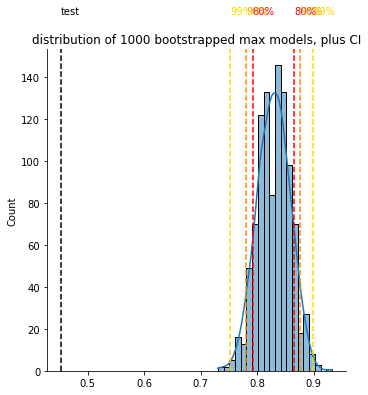

100%|██████████| 1000/1000 [00:10<00:00, 99.52it/s] 


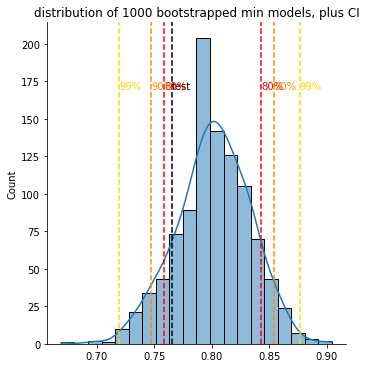

100%|██████████| 1000/1000 [00:13<00:00, 75.42it/s]


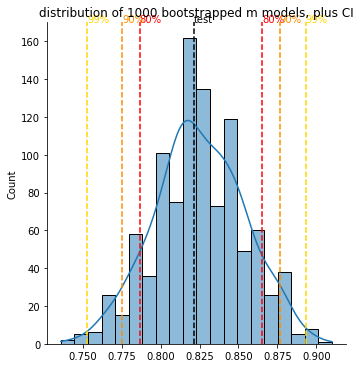

In [2660]:
from sklearn.utils import resample
from tqdm import tqdm # progress bar
for (label,m_i,X_train,y_train,X_test,y_test) in [('max',m_max,X_train_max,y_train,X_test_max,y_test),
                                          ('min',m_minimal,X_train_minimal,y_train,X_test_minimal,y_test),
                                          ('m',m,X_train_fe,y_train,X_test_fe,y_test),
                                          ]:
    boots = []
    split_size = int(len(X_train)*0.75)
    for i in tqdm(range(1000)):
        Xb, yb = resample(X_train, y_train) #bootsrapping random resample
        Xb_train = Xb[:split_size] #train data
        yb_train = yb[:split_size]
        Xb_test = Xb[split_size:] # validation data
        yb_test = yb[split_size:]
        m_i.fit(Xb_train, yb_train) #fit on the train data
        score = m_i.score(Xb_test, yb_test) # score on the val data
        boots.append(score) # save the score
    boots.sort() # sort scores from best to worst - required for my confidence interval levels
    ci80 = boots[100:-100]
    ci90 = boots[50:-50]
    ci99 = boots[5:-5]
    sns.displot(boots, bins=20, kde=True)
    plt.axvline(x=accuracy_score(y_test,m_i.predict(X_test)), color = 'black', linestyle = '--')
    plt.text(s = 'test', x=accuracy_score(y_test,m_i.predict(X_test)), y = 170, color = 'black')
    plt.axvline(x=ci80[0], color = 'red', linestyle = '--')
    plt.axvline(x=ci80[-1], color = 'red', linestyle = '--')
    plt.axvline(x=ci90[0], color = 'darkorange', linestyle = '--')
    plt.axvline(x=ci90[-1], color = 'darkorange', linestyle = '--')
    plt.axvline(x=ci99[0], color = 'gold', linestyle = '--')
    plt.axvline(x=ci99[-1], color = 'gold', linestyle = '--')
    plt.text(s = '80%', x=ci80[0], y = 170, color = 'red')
    plt.text(s = '90%', x=ci90[0], y = 170, color = 'darkorange')
    plt.text(s = '99%', x=ci99[0], y = 170, color = 'gold')
    plt.text(s = '80%', x=ci80[-1], y = 170, color = 'red')
    plt.text(s = '90%', x=ci90[-1], y = 170, color = 'darkorange')
    plt.text(s = '99%', x=ci99[-1], y = 170, color = 'gold')
    plt.title(f'distribution of 1000 bootstrapped {label} models, plus CI')
    plt.show()
    None # just does not write the anoying line

# Desicion Trees

maximum set of features

In [2667]:
clf_Decision_Tree = DecisionTreeClassifier(max_depth=3,)#  min_samples_split=0.7,
clf_Decision_Tree.fit(X_train_max,y_train)
DT_predictions = clf_Decision_Tree.predict(X_test_max)
scores = cross_val_score(clf_Decision_Tree, X_train_max, y_train, cv=5)
print(f"Mean cross-validation score: {scores.mean(): 5.5f}")
print(f"Test score: {accuracy_score(y_test,DT_predictions): 5.5f}")

Mean cross-validation score:  0.81881
Test score:  0.79888


minimum set of features

In [2671]:
clf_Decision_Tree = DecisionTreeClassifier(max_depth=3,)#  min_samples_split=0.7,
clf_Decision_Tree.fit(X_train_minimal,y_train)
DT_predictions = clf_Decision_Tree.predict(X_test_minimal)
scores = cross_val_score(clf_Decision_Tree, X_train_minimal, y_train, cv=5)
print(f"Mean cross-validation score: {scores.mean(): 5.5f}")
print(f"Test score: {accuracy_score(y_test,DT_predictions): 5.5f}")

Mean cross-validation score:  0.79774
Test score:  0.80447


medium set of features

In [2676]:
clf_Decision_Tree = DecisionTreeClassifier(max_depth=3,)#  min_samples_split=0.7,
clf_Decision_Tree.fit(X_train_fe,y_train)
DT_predictions = clf_Decision_Tree.predict(X_test_fe)
scores = cross_val_score(clf_Decision_Tree, X_train_fe, y_train, cv=5)
print(f"Mean cross-validation score: {scores.mean(): 5.5f}")
print(f"Test score: {accuracy_score(y_test,DT_predictions): 5.5f}")

Mean cross-validation score:  0.82022
Test score:  0.79888


Random Forest Classifier

In [2679]:
clf_RF = RandomForestClassifier(max_depth=2, n_estimators=100)
clf_RF.fit(X_train_max,y_train)
scores = cross_val_score(clf_RF, X_train_max, y_train, cv=5)
RF_predictions = clf_RF.predict(X_test_max)
print(f"Mean cross-validation score: {scores.mean(): 5.5f}")
print(f"Test score: {accuracy_score(y_test,RF_predictions): 5.5f}")

Mean cross-validation score:  0.76825
Test score:  0.76536


In [2678]:
clf_RF = RandomForestClassifier(max_depth=2, n_estimators=100)
clf_RF.fit(X_train_minimal,y_train)
scores = cross_val_score(clf_RF, X_train_minimal, y_train, cv=5)
RF_predictions = clf_RF.predict(X_test_minimal)
print(f"Mean cross-validation score: {scores.mean(): 5.5f}")
print(f"Test score: {accuracy_score(y_test,RF_predictions): 5.5f}")

Mean cross-validation score:  0.80334
Test score:  0.74860


In [2680]:
clf_RF = RandomForestClassifier(max_depth=2, n_estimators=100)
clf_RF.fit(X_train_fe,y_train)
scores = cross_val_score(clf_RF, X_train_fe, y_train, cv=5)
RF_predictions = clf_RF.predict(X_test_fe)
print(f"Mean cross-validation score: {scores.mean(): 5.5f}")
print(f"Test score: {accuracy_score(y_test,RF_predictions): 5.5f}")

Mean cross-validation score:  0.75981
Test score:  0.69274
